# End-to-End Pipeline: Prediksi Keberhasilan Telemarketing Bank

**Referensi:** *A Data-Driven Approach to Predict the Success of Bank Telemarketing* (Moro et al., 2014).

**Latar Belakang:**
Mengacu pada riset Moro et al., keberhasilan telemarketing pasca-krisis finansial 2008 sangat dipengaruhi oleh indikator makro ekonomi (seperti Euribor) dan riwayat interaksi dengan nasabah. Proyek ini membangun model prediksi (XGBoost) untuk mengidentifikasi nasabah yang berpotensi membuka deposito berjangka (*Term Deposit*).

**Alur Pengerjaan:**
1.  **Data Preparation:** Cleaning & Feature Engineering.
2.  **Modelling:** XGBoost dengan Hyperparameter Tuning (Optuna).
3.  **Calibration:** Memastikan probabilitas prediksi akurat.
4.  **Business Decision:** Menentukan threshold optimal untuk eksekusi marketing.

In [2]:
# Standard Library & Utilities
import warnings
import joblib
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models & Tuning
import optuna
import shap
from xgboost import XGBClassifier

# Scikit-Learn Components
# Base & Preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Model Selection & Calibration
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.calibration import CalibratedClassifierCV

# Metrics
from sklearn.metrics import (
    auc,
    roc_curve,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve
)

# Configuration
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

print("Libraries loaded successfully.")

c:\Users\Alls\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries loaded successfully.


## 1. Data Loading & Cleaning

Di tahap ini, kita memuat data dan melakukan pembersihan awal.
**Catatan Penting:** Kolom `duration` dihapus sesuai rekomendasi best practice (dan paper Moro et al.) karena durasi telepon tidak diketahui *sebelum* panggilan dilakukan. Jika dibiarkan, ini akan menyebabkan *data leakage*.

In [3]:
df = pd.read_csv("bank-additional-full.csv", sep=';')

# Cek kondisi data awal
print("Jumlah data 'unknown' dari kategorikal:", df.apply(lambda col: col.astype(str).str.contains('unknown', na=False)).sum().sum())
print("Jumlah data kosong:", df.isnull().sum().sum(), "& Jumlah data duplikat:", df.duplicated().sum())

# Cleaning steps
df = (df
    .rename(columns=str.strip)
    .replace('unknown', np.nan)
    .assign(y=lambda x: x['y'].map({'yes': 1, 'no': 0}))
    .drop(columns=['duration'], errors='ignore') # Hapus duration untuk cegah leakage
    .drop_duplicates()
    .reset_index(drop=True)
)

df.head()

Jumlah data 'unknown' dari kategorikal: 12718
Jumlah data kosong: 0 & Jumlah data duplikat: 12


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


## 2. Feature Engineering

Bagian ini adalah inti dari peningkatan performa model. Kita membuat *Custom Transformer* untuk mengekstrak informasi baru yang relevan secara bisnis.

**Strategi Engineering:**
* **Interaksi Ekonomi:** Menggabungkan Euribor (suku bunga) dengan Indeks Kepercayaan Konsumen.
* **Customer History:** Membedakan nasabah baru vs lama.
* **Contact Fatigue:** Menandai nasabah yang terlalu sering ditelepon.

In [4]:
class BankFeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Transformer untuk membuat fitur turunan berdasarkan domain knowledge perbankan.
    
    Fitur Baru:
    -----------
    1. is_new_customer: 
       Menandai jika nasabah belum pernah dihubungi sebelumnya (pdays == 999).
       
    2. high_contact_pressure:
       Menandai nasabah yang sudah dihubungi >4 kali (risiko terganggu/spam).
       
    3. market_condition:
       Interaksi Euribor3m * Consumer Confidence Index. Mencerminkan kondisi makro ekonomi
       yang mempengaruhi minat investasi/deposito (Moro et al., 2014).
       
    4. life_stage:
       Segmentasi demografis berdasarkan umur (Young, Adult, Senior).
    """
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df_eng = X.copy()
        
        # Apakah ini nasabah baru? (999 artinya belum pernah dikontak sebelumnya)
        df_eng['is_new_customer'] = (df_eng['pdays'] == 999).astype(int)
        
        # Apakah nasabah sering ditelepon? (>4 kali dianggap mengganggu)
        df_eng['high_contact_pressure'] = (df_eng['campaign'] > 4).astype(int)
        
        # Kondisi pasar: Suku bunga x Kepercayaan Konsumen
        df_eng['market_condition'] = df_eng['euribor3m'] * df_eng['cons.conf.idx']
        
        # Segmentasi Umur
        conditions = [
            (df_eng['age'] < 30),
            (df_eng['age'] >= 30) & (df_eng['age'] <= 60),
            (df_eng['age'] > 60)
        ]
        df_eng['life_stage'] = np.select(conditions, [0, 1, 2], default=1)
        return df_eng

# Definisi Kolom
original_num_cols = [
    'age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
    'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'
]
new_eng_cols = ['is_new_customer', 'high_contact_pressure', 'market_condition', 'life_stage']
num_cols = original_num_cols + new_eng_cols

cat_cols = [
    'job', 'marital', 'education', 'default', 'housing', 'loan', 
    'contact', 'month', 'day_of_week', 'poutcome'
]

# Split Data
X = df.drop(columns='y')
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Definisi Pipeline Preprocessing
preprocessing_pipeline = Pipeline(steps=[
    ('feature_engineering', BankFeatureEngineer()), # Buat fitur baru
    
    ('col_transformer', ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), num_cols),
            
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), cat_cols)
        ],
        remainder='drop'
    ))
])

print("Melakukan Feature Engineering & Preprocessing...")
X_train_prep = preprocessing_pipeline.fit_transform(X_train)
X_test_prep = preprocessing_pipeline.transform(X_test)

# Mengambil nama fitur setelah One-Hot Encoding untuk keperluan visualisasi nanti
ohe_feature_names = preprocessing_pipeline.named_steps['col_transformer']\
    .named_transformers_['cat']['onehot'].get_feature_names_out(cat_cols)

feature_names = np.concatenate([num_cols, ohe_feature_names])

print(f"Shape data training: {X_train_prep.shape}")
print(f"Total fitur yang digunakan: {len(feature_names)}")

Melakukan Feature Engineering & Preprocessing...
Shape data training: (31523, 66)
Total fitur yang digunakan: 66


## 3. Modelling: XGBoost dengan Optuna

Karena data tidak seimbang (*imbalanced*), kita menggunakan metric **ROC_AUC** sebagai target optimasi. Optuna digunakan untuk mencari kombinasi parameter terbaik (jumlah pohon, kedalaman, learning rate, dll).

In [5]:
def objective(trial):
    """
    Objective function untuk Optuna.
    Mencari parameter XGBoost yang memaksimalkan skor ROC_AUC cross-validation.
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10), # Untuk imbalanced data (menghindari smote yang merusak prediktif)
        'n_jobs': -1,
        'random_state': 42,
        'eval_metric': 'logloss'
    }
    
    model = XGBClassifier(**params)
    
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_prep, y_train, cv=cv, scoring='average_precision', n_jobs=-1)
    
    return scores.mean()

# Jalankan optimasi
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20) # Diset 20 trial agar cepat (dapat dinaikkan untuk hasil lebih baik)

print("\nBest Params:", study.best_params)

[I 2025-12-12 22:55:58,163] A new study created in memory with name: no-name-78e377aa-948c-4281-8ed1-0822790a5039
[I 2025-12-12 22:56:03,269] Trial 0 finished with value: 0.47026904533102315 and parameters: {'n_estimators': 506, 'max_depth': 4, 'learning_rate': 0.07094802060505787, 'subsample': 0.823891106245669, 'colsample_bytree': 0.7868757950725418, 'gamma': 2.0282943326755043, 'reg_alpha': 2.40635750404619, 'reg_lambda': 0.7151081615280419, 'scale_pos_weight': 1.246312338272023}. Best is trial 0 with value: 0.47026904533102315.
[I 2025-12-12 22:56:09,242] Trial 1 finished with value: 0.46146044651459145 and parameters: {'n_estimators': 712, 'max_depth': 7, 'learning_rate': 0.04151970786753508, 'subsample': 0.7821163196665424, 'colsample_bytree': 0.9294065654040887, 'gamma': 4.994763693792475, 'reg_alpha': 2.796458845265718, 'reg_lambda': 2.698069900341939, 'scale_pos_weight': 7.05678641108551}. Best is trial 0 with value: 0.47026904533102315.
[I 2025-12-12 22:56:18,088] Trial 2 fin


Best Params: {'n_estimators': 640, 'max_depth': 5, 'learning_rate': 0.030367678961434955, 'subsample': 0.6990159226216422, 'colsample_bytree': 0.8209003953047949, 'gamma': 3.4818717634031415, 'reg_alpha': 1.2769947614068164, 'reg_lambda': 2.7026086870945445, 'scale_pos_weight': 1.0715062629096923}


## 4. Model Calibration

Skor mentah dari XGBoost seringkali tidak merepresentasikan probabilitas sebenarnya. Kita menggunakan `CalibratedClassifierCV` (Isotonic Regression) agar probabilitas yang dihasilkan (misal: 70%) benar-benar berarti "ada peluang 70% nasabah ini akan setuju".

In [6]:
# Ambil parameter terbaik dari Optuna
best_params = study.best_params
best_params['n_jobs'] = -1
best_params['random_state'] = 42

# Inisialisasi model dasar
xgb_best = XGBClassifier(**best_params)

# Bungkus dengan CalibratedClassifierCV
calibrated_model = CalibratedClassifierCV(estimator=xgb_best, method='sigmoid', cv=5)

# Training model akhir
calibrated_model.fit(X_train_prep, y_train)
print("Melatih model terkalibrasi selesai.")

Melatih model terkalibrasi selesai.


## 5. Strategi Bisnis & Thresholding

Kita tidak menggunakan threshold default 0.5. Kita mencari threshold dinamis berdasarkan 3 skenario bisnis:
1.  **Growth (Max F1):** Seimbang antara kuantitas dan kualitas leads.
2.  **Sniper (High Precision):** Hanya menelepon nasabah yang sangat yakin akan beli (hemat biaya operasional).
3.  **Balance (Intersection):** Titik temu antara Precision dan Recall.

3 OPSI THRESHOLD (SEGMENTASI & BALANCE)
1. HOT Leads (Top 10%)  -> Threshold: 0.2841 (Prioritas Utama)
2. WARM Leads (Top 30%) -> Threshold: 0.0685 (Prioritas Kedua)
3. Intersection (Balance)  -> Threshold: 0.2324 (Titik temu Presisi & Recall)


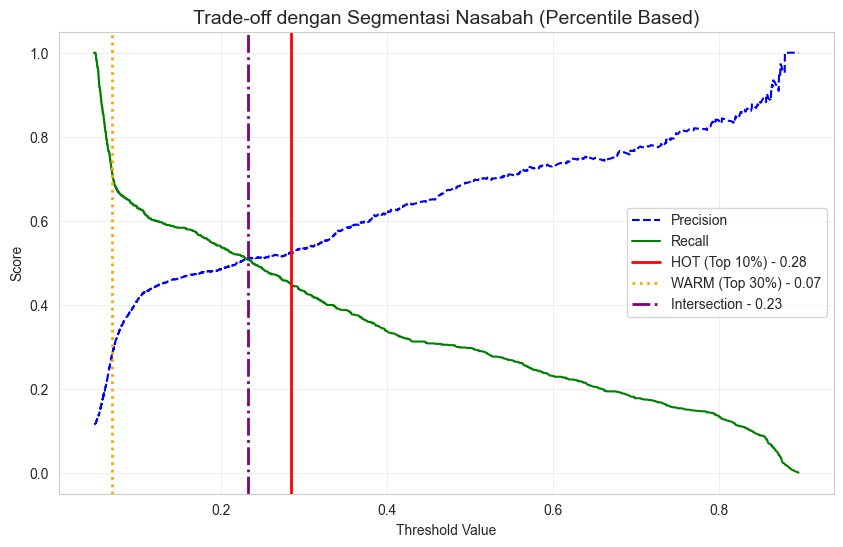

In [17]:
# Prediksi probabilitas pada data test
y_probs_test = calibrated_model.predict_proba(X_test_prep)[:, 1]

# Hitung Precision-Recall Curve untuk keperluan plotting dan Intersection
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs_test)

# 1. Hot Lead (Top 10% Nasabah dengan probabilitas tertinggi)
t_hot = np.percentile(y_probs_test, 90)

# 2. Warm Lead (Top 30% Nasabah)
t_warm = np.percentile(y_probs_test, 70)

# 3. Intersection (Balance)
diff = np.abs(precisions[:-1] - recalls[:-1])
idx_int = np.argmin(diff)
t_int = thresholds[idx_int]

print(f"3 OPSI THRESHOLD (SEGMENTASI & BALANCE)")
print(f"1. HOT Leads (Top 10%)  -> Threshold: {t_hot:.4f} (Prioritas Utama)")
print(f"2. WARM Leads (Top 30%) -> Threshold: {t_warm:.4f} (Prioritas Kedua)")
print(f"3. Intersection (Balance)  -> Threshold: {t_int:.4f} (Titik temu Presisi & Recall)")

# Visualisasi Precision-Recall Tradeoff
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')

# Plot garis vertikal
plt.axvline(t_hot, color='red', linestyle='-', linewidth=2, label=f'HOT (Top 10%) - {t_hot:.2f}')
plt.axvline(t_warm, color='orange', linestyle=':', linewidth=2, label=f'WARM (Top 30%) - {t_warm:.2f}')
plt.axvline(t_int, color='purple', linestyle='-.', linewidth=2, label=f'Intersection - {t_int:.2f}')

plt.title('Trade-off dengan Segmentasi Nasabah (Percentile Based)', fontsize=14)
plt.xlabel('Threshold Value')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

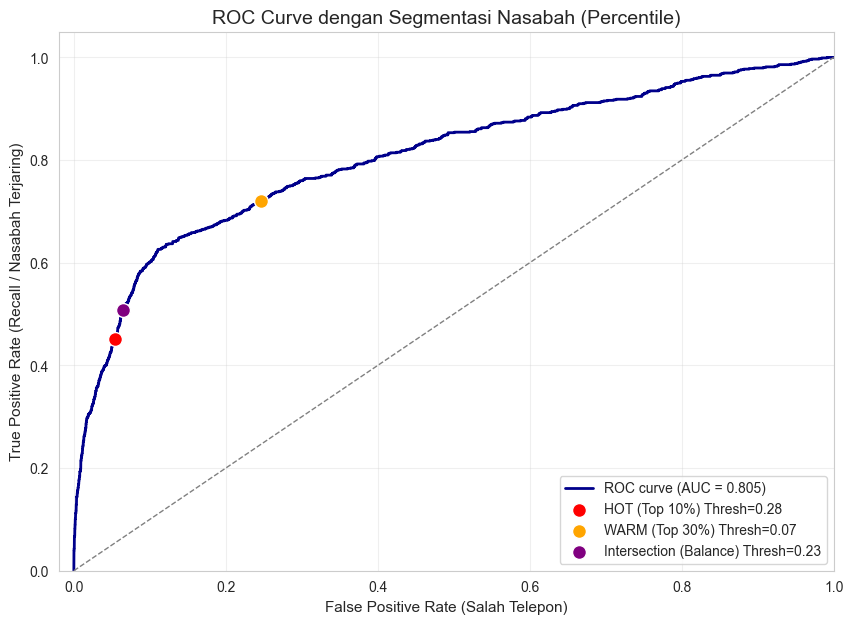

In [16]:
# 1. Hitung False Positive Rate (FPR) dan True Positive Rate (TPR)
fpr, tpr, roc_thresholds = roc_curve(y_test, y_probs_test)
roc_auc = auc(fpr, tpr)

# 2. Fungsi helper 
def find_roc_coords(target_threshold, rocc_threshs, fprs, tprs):
    idx = np.argmin(np.abs(rocc_threshs - target_threshold))
    return fprs[idx], tprs[idx]

# 3. Dapatkan koordinat untuk 3 strategi bisnis
fpr_hot, tpr_hot = find_roc_coords(t_hot, roc_thresholds, fpr, tpr)
fpr_warm, tpr_warm = find_roc_coords(t_warm, roc_thresholds, fpr, tpr)
fpr_int, tpr_int = find_roc_coords(t_int, roc_thresholds, fpr, tpr)

# 4. Plotting
plt.figure(figsize=(10, 7))

# Garis utama ROC
plt.plot(fpr, tpr, color='darkblue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--') # Garis random

# Plot titik strategi bisnis (UPDATE LABEL & WARNA)
# - HOT Leads (Merah)
# - WARM Leads (Oranye)
# - Intersection (Ungu)
plt.scatter(fpr_hot, tpr_hot, s=100, c='red', label=f'HOT (Top 10%) Thresh={t_hot:.2f}', zorder=5, edgecolors='white')
plt.scatter(fpr_warm, tpr_warm, s=100, c='orange', label=f'WARM (Top 30%) Thresh={t_warm:.2f}', zorder=5, edgecolors='white')
plt.scatter(fpr_int, tpr_int, s=100, c='purple', label=f'Intersection (Balance) Thresh={t_int:.2f}', zorder=5, edgecolors='white')

# Anotasi dan Label
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Salah Telepon)', fontsize=11)
plt.ylabel('True Positive Rate (Recall / Nasabah Terjaring)', fontsize=11)
plt.title('ROC Curve dengan Segmentasi Nasabah (Percentile)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.show()

## 6. Explainability dengan SHAP

Mengapa model memprediksi nasabah tertentu akan deposito? Kita menggunakan **SHAP Values** untuk melihat kontribusi setiap fitur. Ini menjawab kekhawatiran "Black Box" pada model machine learning.

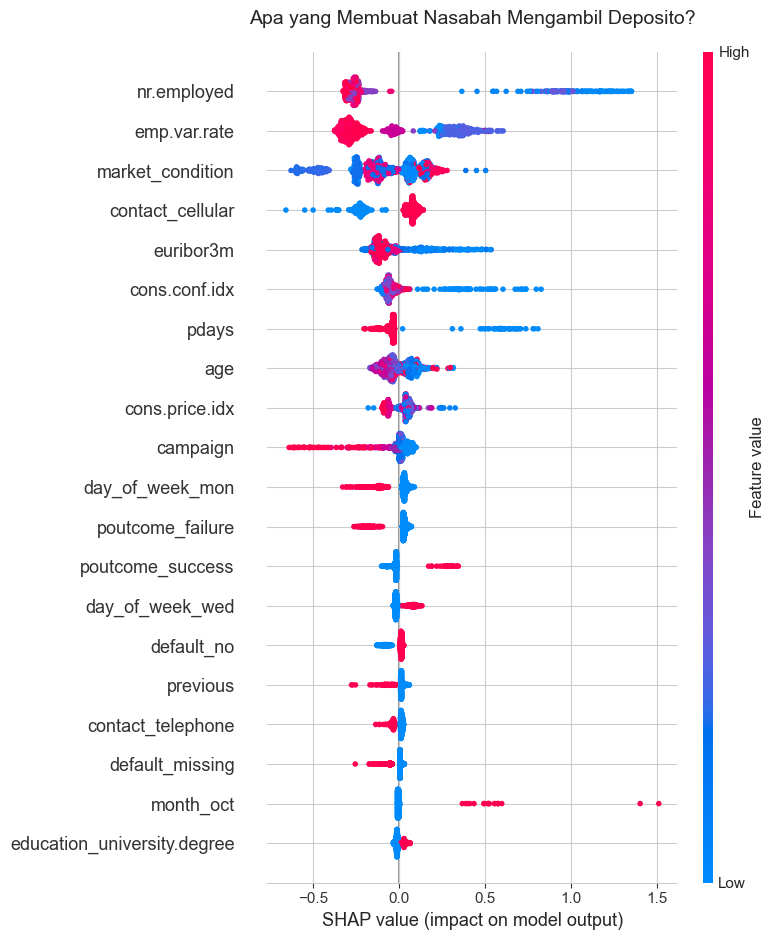

In [18]:
# Kita perlu melatih ulang XGBoost murni (tanpa wrapper Calibrated) untuk TreeExplainer
# karena CalibratedClassifierCV tidak support SHAP secara langsung.
xgb_explain = XGBClassifier(**best_params)
xgb_explain.fit(X_train_prep, y_train)

explainer = shap.TreeExplainer(xgb_explain)
X_shap = X_test_prep[:1000]  # Ambil sampel 1000 data agar visualisasi cepat
shap_values = explainer.shap_values(X_shap)

plt.figure(figsize=(10, 8))
plt.title("Apa yang Membuat Nasabah Mengambil Deposito?", fontsize=14, pad=20)
shap.summary_plot(shap_values, X_shap, feature_names=feature_names, show=False)
plt.tight_layout()
plt.show()

## 7. Evaluasi Performa Strategi

Di sini kita melihat dampak nyata dari pemilihan threshold terhadap Confusion Matrix. Perhatikan pergeseran jumlah **False Positives** (salah telepon) saat threshold dinaikkan.

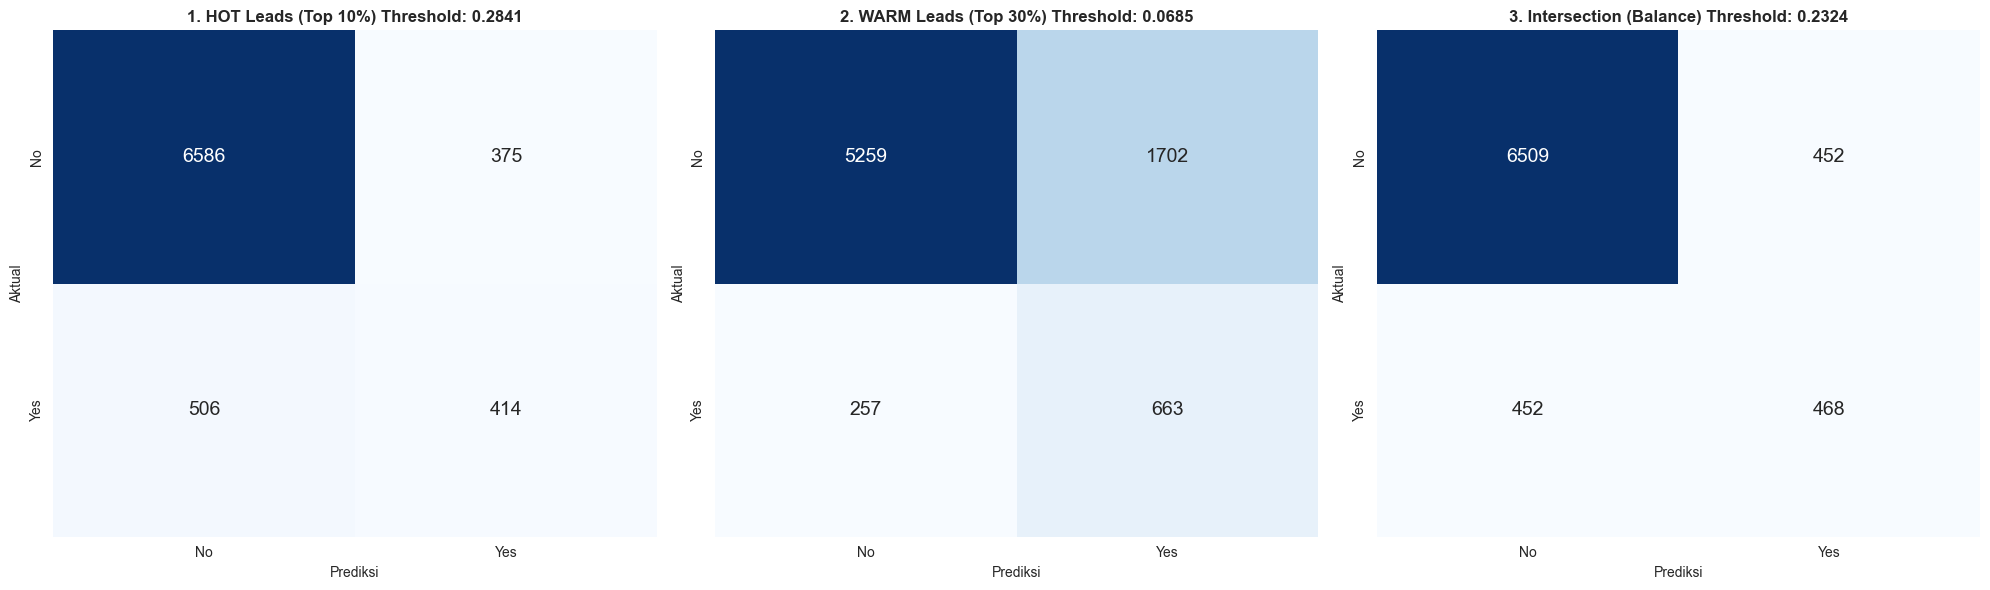

1. HOT Leads (Top 10%) (Threshold: 0.2841)
              precision    recall  f1-score   support

          No       0.93      0.95      0.94      6961
         Yes       0.52      0.45      0.48       920

    accuracy                           0.89      7881
   macro avg       0.73      0.70      0.71      7881
weighted avg       0.88      0.89      0.88      7881

2. WARM Leads (Top 30%) (Threshold: 0.0685)
              precision    recall  f1-score   support

          No       0.95      0.76      0.84      6961
         Yes       0.28      0.72      0.40       920

    accuracy                           0.75      7881
   macro avg       0.62      0.74      0.62      7881
weighted avg       0.87      0.75      0.79      7881

3. Intersection (Balance) (Threshold: 0.2324)
              precision    recall  f1-score   support

          No       0.94      0.94      0.94      6961
         Yes       0.51      0.51      0.51       920

    accuracy                           0.89      

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

strategies = [
    ("1. HOT Leads (Top 10%)", t_hot),          
    ("2. WARM Leads (Top 30%)", t_warm), 
    ("3. Intersection (Balance)", t_int)    
]

for i, (name, thresh) in enumerate(strategies):
    # Probabilitas >= threshold, maka prediksi 1 (Yes)
    y_pred_temp = (y_probs_test >= thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred_temp)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False, annot_kws={"size": 14})
    axes[i].set_title(f'{name} Threshold: {thresh:.4f}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Prediksi', fontsize=10)
    axes[i].set_ylabel('Aktual', fontsize=10)
    axes[i].set_xticklabels(['No', 'Yes'])
    axes[i].set_yticklabels(['No', 'Yes'])

plt.tight_layout()
plt.show()

# Print Classification Report
for name, thresh in strategies:
    print(f"{name} (Threshold: {thresh:.4f})")
    y_pred_strategy = (y_probs_test >= thresh).astype(int)
    print(classification_report(y_test, y_pred_strategy, target_names=['No', 'Yes']))

## 8. Final Pipeline & Serialisasi

Terakhir, kita menggabungkan `Preprocessing` dan `Model` menjadi satu objek Pipeline utuh dan menyimpannya ke file `.pkl`. File ini siap digunakan oleh tim Backend/IT untuk memprediksi data nasabah baru di masa depan.

In [31]:
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessing_pipeline),
    ('model', calibrated_model)
])

try:
    # Tes prediksi dummy untuk memastikan pipeline berjalan
    demo_pred = final_pipeline.predict_proba(X_test.head())[:, 1]
    print("Tes Pipeline Berhasil. Contoh Output Probabilitas:")
    print(demo_pred)
    
    # Simpan model
    filename = 'model_deposito_siap_pakai.pkl'
    joblib.dump(final_pipeline, filename)
    
    print(f"\nModel berhasil disimpan sebagai '{filename}'")
    print("Siap untuk deployment.")
    
except Exception as e:
    print("Ada error saat menggabungkan pipeline:", e)

Tes Pipeline Berhasil. Contoh Output Probabilitas:
[0.05588548 0.08567317 0.06391825 0.0603623  0.04869337]

Model berhasil disimpan sebagai 'model_deposito_siap_pakai.pkl'
Siap untuk deployment.
